In [1]:
import pandas as pd

# Load the CSV file
file_path = '/kaggle/input/vegi-price/beans-with-dollar.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1459 non-null   object 
 1   Kandy          1459 non-null   float64
 2   Dambulla       1459 non-null   float64
 3   Exchange Rate  1459 non-null   float64
dtypes: float64(3), object(1)
memory usage: 45.7+ KB


(         Date       Kandy    Dambulla  Exchange Rate
 0  2020-01-01  310.000000  315.000000         181.50
 1  2020-01-02  274.166667  279.166667         181.03
 2  2020-01-03  238.333333  243.333333         181.37
 3  2020-01-04  202.500000  207.500000         181.35
 4  2020-01-05  166.666667  171.666667         181.34,
 None)

In [2]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Assume df is your DataFrame that includes 'Kandy', 'Dambulla', and 'Buy Rate'

# Create a lagged feature for 'Buy Rate' with a lag of 30 days
df['Buy Rate Lagged'] = df['Exchange Rate'].shift(7)

# Drop the first 30 rows since they will have NaN values due to the shift
df = df.dropna().reset_index(drop=True)

# Normalize the data (including Kandy, Dambulla, and Buy Rate Lagged)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['Kandy', 'Dambulla', 'Buy Rate Lagged']])

# Function to create sequences for LSTM
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Input sequence
        y.append(data[i+seq_length][:2])  # Target sequence (next step)
    return np.array(X), np.array(y)

# Define sequence length
seq_length = 7

# Create sequences
X, y = create_sequences(scaled_data, seq_length)

# Split the data into training, validation, and test sets
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_index = int(len(X) * train_ratio)
val_index = int(len(X) * (train_ratio + val_ratio))

X_train, X_val, X_test = X[:train_index], X[train_index:val_index], X[val_index:]
y_train, y_val, y_test = y[:train_index], y[train_index:val_index], y[val_index:]

# Display the shape of the resulting arrays
print("Training Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

Training Set: (1011, 7, 3) (1011, 2)
Validation Set: (217, 7, 3) (217, 2)
Test Set: (217, 7, 3) (217, 2)


In [3]:
# Convert 'Date' to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Check for missing values
missing_values = df.isnull().sum()

# Display the result
df.set_index('Date', inplace=True)
df = df[['Kandy', 'Dambulla', 'Exchange Rate']]  # We will focus on these two columns for LSTM
missing_values, df.head()

(Date               0
 Kandy              0
 Dambulla           0
 Exchange Rate      0
 Buy Rate Lagged    0
 dtype: int64,
                  Kandy    Dambulla  Exchange Rate
 Date                                             
 2020-01-08  126.666667  121.666667         181.31
 2020-01-09  158.333333  143.333333         181.42
 2020-01-10  190.000000  165.000000         181.42
 2020-01-11  207.500000  170.000000         181.41
 2020-01-12  225.000000  175.000000         181.41)

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras import mixed_precision
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping
import shutil
import os

tuner_directory = 'my_dir/bilstm_hyperparameter_tuning'

if os.path.exists(tuner_directory):
    shutil.rmtree(tuner_directory)

# Enable mixed precision training
mixed_precision.set_global_policy('mixed_float16')

# Define a function that builds the Bi-LSTM model with hyperparameters
def build_model(hp):
    model = Sequential()
    
    # First Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units1', min_value=16, max_value=64, step=16),
                                 return_sequences=True), input_shape=(seq_length, 3)))
    model.add(Dropout(hp.Float('dropout_rate1', 0.1, 0.5, step=0.1)))
    
    # Second Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units2', min_value=16, max_value=64, step=16),
                                 return_sequences=True)))
    model.add(Dropout(hp.Float('dropout_rate2', 0.1, 0.5, step=0.1)))
    
    # Third Bidirectional LSTM layer
    model.add(Bidirectional(LSTM(units=hp.Int('units3', min_value=16, max_value=64, step=16),
                                 return_sequences=False)))
    model.add(Dropout(hp.Float('dropout_rate3', 0.1, 0.5, step=0.1)))
    
    # First Dense layer
    model.add(Dense(
        units=hp.Int('dense_units1', min_value=16, max_value=64, step=16),
        activation=hp.Choice('dense_activation1', values=['relu', 'tanh', 'sigmoid', 'elu', 'selu'])
    ))
    
    # Second Dense layer
    model.add(Dense(
        units=hp.Int('dense_units2', min_value=16, max_value=64, step=16),
        activation=hp.Choice('dense_activation2', values=['relu', 'tanh', 'sigmoid', 'elu', 'selu'])
    ))

    # Output layer
    model.add(Dense(2, dtype='float32'))  # Output layer with 2 outputs

    # Compile the model
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2, 1e-1])  # Trying different learning rates
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mean_squared_error')
    
    return model

# Define a tuner using RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=5,
    directory='my_dir',
    project_name='bilstm_hyperparameter_tuning'
)

# Convert data to tf.data pipelines
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.AUTOTUNE)

# Run the hyperparameter search
tuner.search(train_dataset, epochs=200, validation_data=val_dataset, callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Optionally, retrain the best model
history = best_model.fit(train_dataset, epochs=200, validation_data=val_dataset, verbose=1)

Trial 20 Complete [00h 02m 25s]
val_loss: 0.014289455860853196

Best val_loss So Far: 0.012828675284981727
Total elapsed time: 00h 25m 36s
Best Hyperparameters: {'units1': 48, 'dropout_rate1': 0.4, 'units2': 32, 'dropout_rate2': 0.2, 'units3': 48, 'dropout_rate3': 0.1, 'dense_units1': 64, 'dense_activation1': 'relu', 'dense_units2': 32, 'dense_activation2': 'elu', 'learning_rate': 0.0001}
Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0065 - val_loss: 0.0123
Epoch 2/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0065 - val_loss: 0.0137
Epoch 3/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0077 - val_loss: 0.0130
Epoch 4/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0069 - val_loss: 0.0122
Epoch 5/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - val_loss: 0.0130
Epoch 6/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0067 - val_loss: 0.0121
Epoch 7/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0066 - val_loss: 0.0126
Epoch 8/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0069 - val_loss: 0.0128
Epoch 9/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0067 - val_loss: 0.0121
Epoch 10/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0063 - val_loss: 0.0123
Epoch 11/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0066 - val_loss: 0.0122
Epoch 12/200
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0

In [5]:
# Make predictions on the test dataset
predictions = best_model.predict(test_dataset)

# Optionally, you can also predict on a single batch of test data:
# predictions = model.predict(X_test[:batch_size])

# Print the predictions
print(predictions)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
[[0.43743563 0.5121444 ]
 [0.43851775 0.520537  ]
 [0.40035665 0.47345558]
 [0.3572434  0.40940142]
 [0.42009246 0.48085466]
 [0.40076035 0.45030758]
 [0.43434715 0.48742875]
 [0.4421106  0.49797437]
 [0.43493634 0.4915897 ]
 [0.42244217 0.47849587]
 [0.4098826  0.46432596]
 [0.42621416 0.4923232 ]
 [0.44207722 0.51154804]
 [0.43828878 0.5049106 ]
 [0.33464074 0.377858  ]
 [0.3861581  0.44759083]
 [0.38396996 0.44735786]
 [0.51265377 0.60496783]
 [0.51890224 0.609416  ]
 [0.5105855  0.59923315]
 [0.5043388  0.5872936 ]
 [0.495888   0.5711297 ]
 [0.5049427  0.5746223 ]
 [0.5252427  0.5892514 ]
 [0.5342278  0.5959593 ]
 [0.5448984  0.6061574 ]
 [0.55148745 0.60450757]
 [0.5420251  0.5912329 ]
 [0.56222034 0.61704206]
 [0.5782193  0.6386782 ]
 [0.589115   0.65409446]
 [0.59568846 0.6634606 ]
 [0.6015192  0.66872406]
 [0.62190515 0.686885  ]
 [0.5893977  0.6382781 ]
 [0.53030205 0.55997336]
 [0.49663222 0.51600814]
 [0.47645554 0.4916725 ]
 [0.4610657

In [6]:
predictions_rescaled = scaler.inverse_transform(
    np.concatenate([predictions, np.zeros((predictions.shape[0], 1))], axis=1)
)[:, :2]

print("Rescaled Predictions:", predictions_rescaled)

Rescaled Predictions: [[313.08701992 321.55796885]
 [313.72547209 326.08999014]
 [291.21042371 300.66601217]
 [265.77359945 266.07676506]
 [302.85455346 304.66151655]
 [291.44860804 288.16609204]
 [311.2648201  308.21152747]
 [315.84525287 313.90615761]
 [311.61244333 310.45843542]
 [304.24087912 303.38776767]
 [296.83073699 295.7360208 ]
 [306.46635354 310.85452259]
 [315.8255595  321.23594284]
 [313.59037906 317.65171766]
 [252.4380374  249.04332697]
 [282.83328414 286.69904709]
 [281.54227793 286.57324612]
 [357.46572316 371.68262959]
 [361.15232289 374.08464432]
 [356.24543726 368.58590126]
 [352.55989254 362.13855743]
 [347.57391691 353.41002703]
 [352.91620195 355.29602766]
 [364.8931849  363.19575548]
 [370.19439518 366.81802511]
 [376.49005055 372.32500792]
 [380.37759304 371.43408537]
 [374.79480267 364.26576376]
 [386.70999765 378.20271492]
 [396.14938378 389.88622427]
 [402.57786393 398.21100712]
 [406.45619273 403.26873064]
 [409.89634395 406.11099243]
 [421.92403734 415.91

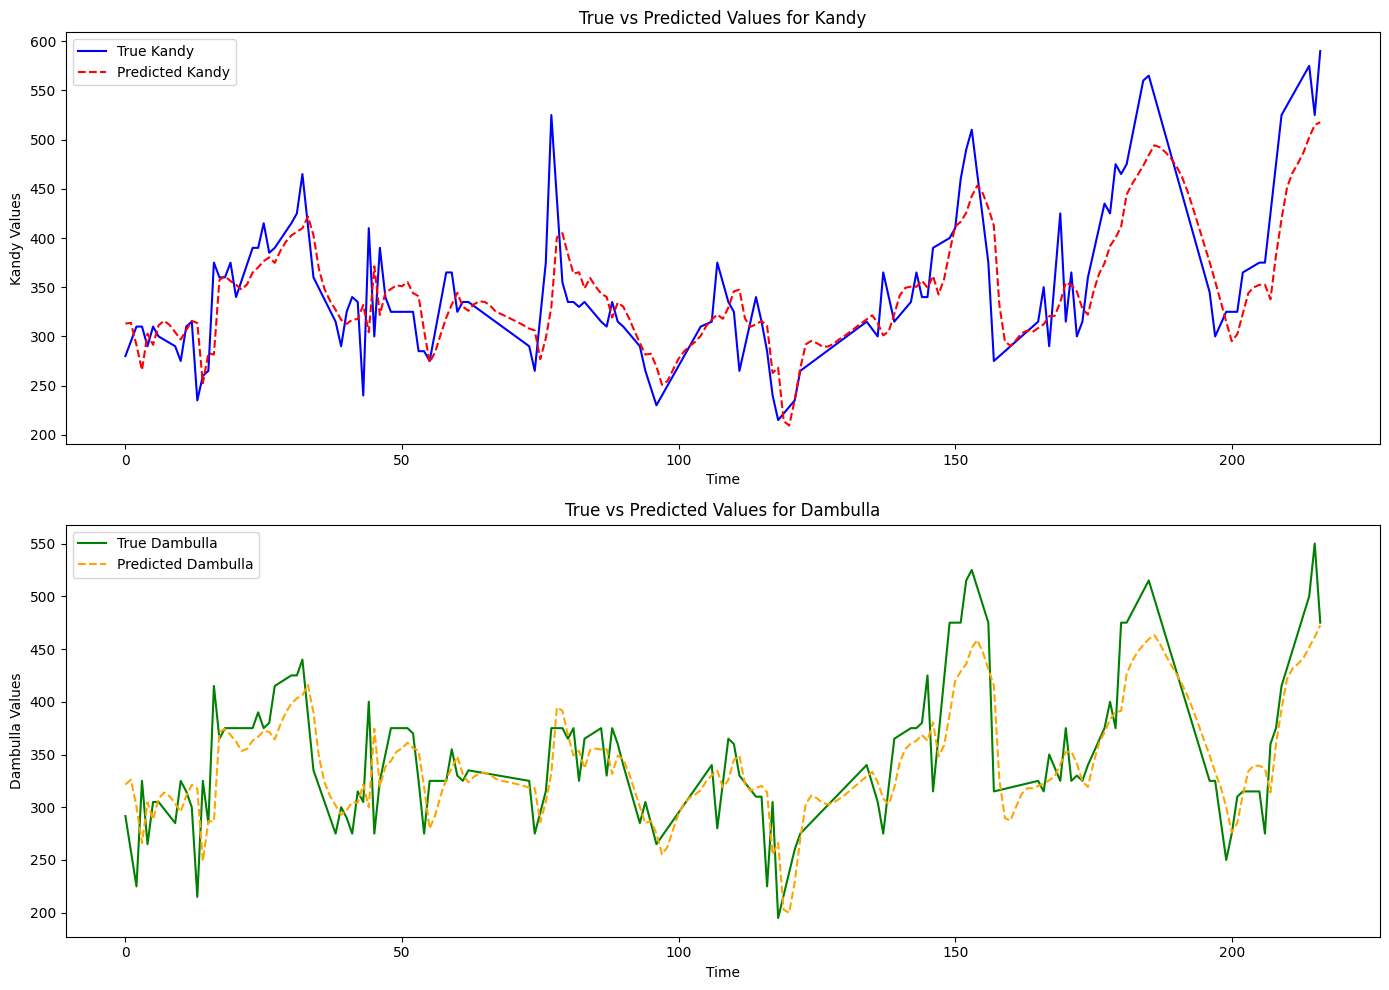

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Rescale the predictions and y_test to original scale
y_test_rescaled = scaler.inverse_transform(
    np.concatenate([y_test, np.zeros((y_test.shape[0], 1))], axis=1)
)[:, :2]



# Create two subplots for 'Kandy' and 'Dambulla'
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

# Plot for Kandy
ax[0].plot(y_test_rescaled[:, 0], color='blue', label='True Kandy')
ax[0].plot(predictions_rescaled[:, 0], color='red', linestyle='--', label='Predicted Kandy')
ax[0].set_title('True vs Predicted Values for Kandy')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Kandy Values')
ax[0].legend()

# Plot for Dambulla
ax[1].plot(y_test_rescaled[:, 1], color='green', label='True Dambulla')
ax[1].plot(predictions_rescaled[:, 1], color='orange', linestyle='--', label='Predicted Dambulla')
ax[1].set_title('True vs Predicted Values for Dambulla')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Dambulla Values')
ax[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


In [8]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error


# Calculate the Mean Squared Error (MSE) for each target ('Kandy' and 'Dambulla')
mse_kandy = mean_squared_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0])
mse_dambulla = mean_squared_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1])

# Print the MSE results
print(f"MSE for Kandy: {mse_kandy}")
print(f"MSE for Dambulla: {mse_dambulla}")

# Calculate the RMSE for each target ('Kandy' and 'Dambulla')
rmse_kandy = np.sqrt(mean_squared_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0]))
rmse_dambulla = np.sqrt(mean_squared_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1]))

# Print the RMSE results
print(f"RMSE for Kandy: {rmse_kandy}")
print(f"RMSE for Dambulla: {rmse_dambulla}")

# Calculate the RMSLE for each target ('Kandy' and 'Dambulla')
rmsle_kandy = np.sqrt(mean_squared_log_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0]))
rmsle_dambulla = np.sqrt(mean_squared_log_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1]))

from sklearn.metrics import mean_absolute_percentage_error

# Calculate the MAPE for each target ('Kandy' and 'Dambulla')
mape_kandy = mean_absolute_percentage_error(y_test_rescaled[:, 0], predictions_rescaled[:, 0])
mape_dambulla = mean_absolute_percentage_error(y_test_rescaled[:, 1], predictions_rescaled[:, 1])

# Print the MAPE results
print(f"MAPE for Kandy: {mape_kandy * 100:.2f}%")
print(f"MAPE for Dambulla: {mape_dambulla * 100:.2f}%")

# Print the RMSLE results
print(f"RMSLE for Kandy: {rmsle_kandy}")
print(f"RMSLE for Dambulla: {rmsle_dambulla}")

MSE for Kandy: 1588.3986594126288
MSE for Dambulla: 1149.4914652436053
RMSE for Kandy: 39.85471941204239
RMSE for Dambulla: 33.90415115061289
MAPE for Kandy: 7.97%
MAPE for Dambulla: 7.20%
RMSLE for Kandy: 0.10750057158012118
RMSLE for Dambulla: 0.10022092287100019
